## Import Statements 

In [1]:
import os,sys
sys.path.append(os.path.abspath('..'))
from octcv.arrViz import *

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv3D,Conv2D,Dense,MaxPool2D,MaxPool3D,Flatten,Dropout,\
BatchNormalization,GlobalAveragePooling3D,GlobalAveragePooling2D,ReLU,Input
from keras.metrics import AUC
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras import Model as kerasModel

## Loading Modeling/Pre-processed Datasets 

In [3]:
c_test = pd.read_csv('./combined_slices_TEST.csv')
c_train = pd.read_csv('./combined_slices_train.csv')

v_test = pd.read_csv('./volumes_TEST.csv')
v_train = pd.read_csv('./volumes_train.csv')

c_test.shape, c_train.shape, v_test.shape, v_train.shape

((232, 8), (926, 8), (222, 8), (888, 8))

In [4]:
v_train.head()

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_volume
0,glaucoma,1,347,OS,1,1,../datasrc/volumesOCT/normalized/p347_Glaucoma...,../datasrc/volumesOCT/POAG-001887-2008-01-31-O...
1,normal,0,560,OD,0,1,../datasrc/volumesOCT/normalized/p560_Normal_O...,../datasrc/volumesOCT/Normal-003164-2012-03-06...
2,glaucoma,1,398,OD,0,1,../datasrc/volumesOCT/normalized/p398_Glaucoma...,../datasrc/volumesOCT/POAG-002184-2011-06-14-O...
3,glaucoma,1,475,OS,1,1,../datasrc/volumesOCT/normalized/p475_Glaucoma...,../datasrc/volumesOCT/POAG-002636-2008-05-20-O...
4,normal,0,553,OD,0,1,../datasrc/volumesOCT/normalized/p553_Normal_O...,../datasrc/volumesOCT/Normal-003120-2009-12-17...


In [5]:
c_train.head()

,dx_class,glaucoma,PIN,laterality,left_eye,set,normalized_array,display_image
0,glaucoma,1,33,OS,1,1,../datasrc/fundus-oct-composite/normalized/p03...,../datasrc/volumesOCT/bslices/POAG-000275-2010...
1,glaucoma,1,184,OD,0,1,../datasrc/fundus-oct-composite/normalized/p18...,../datasrc/volumesOCT/bslices/POAG-000994-2009...
2,glaucoma,1,184,OS,1,1,../datasrc/fundus-oct-composite/normalized/p18...,../datasrc/volumesOCT/bslices/POAG-000994-2009...
3,glaucoma,1,520,OS,1,1,../datasrc/fundus-oct-composite/normalized/p52...,../datasrc/volumesOCT/bslices/POAG-002903-2013...
4,normal,0,35,OS,1,1,../datasrc/fundus-oct-composite/normalized/p03...,../datasrc/volumesOCT/bslices/Normal-000301-20...


For the case of a unimodal CNN, the entirety of X will be the image data - however, to conserve RAM, will keep as filepaths for now and define a custom function to load the arrays for a given set during training.

In [6]:
def yX_split(df):
    yvals = df.glaucoma.values
    yinv =  (df.glaucoma - 1).abs().values
    y = np.stack((yvals,yinv),axis=1)
    disp_col = [ c for c in df.columns if c.startswith('display') ][0]
    X_paths = df[['normalized_array',disp_col]]
    return y,X_paths

# Volume Dataset
vy_test,vX_test_paths = yX_split(v_test)
vy_train,vX_train_paths = yX_split(v_train)
print(f"\n3D Volumes - train_test shapes:")
print(f"\tTrain Set(y,X): {vy_test.shape,vX_test_paths.shape}")
print(f"\tTest Set(y,X): {vy_train.shape,vX_train_paths.shape}")

y_test,X_test_paths = yX_split(c_test)
y_train,X_train_paths = yX_split(c_train)
print(f"\nCombined 2D Images - train_test shapes:")
print(f"\tTrain Set(y,X): {y_test.shape,X_test_paths.shape}")
print(f"\tTest Set(y,X): {y_train.shape,X_train_paths.shape}\n")


3D Volumes - train_test shapes:
	Train Set(y,X): ((222, 2), (222, 2))
	Test Set(y,X): ((888, 2), (888, 2))

Combined 2D Images - train_test shapes:
	Train Set(y,X): ((232, 2), (232, 2))
	Test Set(y,X): ((926, 2), (926, 2))



In [7]:
def load_images(image_paths,normalized=True):
    # shape: (N, 64, 128, 64)
    nrows,ncols = np.array(image_paths).shape
    if ncols == 2:
        if type(image_paths)==pd.DataFrame:
            # col_name = 'normalized_array' if normalized else [ c for c in image_paths.columns if c.startswith('display') ][0]
            col_name = 'normalized_array'
            xarrs = image_paths[col_name].apply(vizInputParser).values
            xarrs = np.stack(xarrs,axis=0)
        elif type(image_paths)==np.ndarray or type(image_paths)==list:
            col_index = 0 if normalized else 1
            xarrs = np.array([vizInputParser(path) for path in image_paths[:,col_index]]) # shape: (N, 64, 128, 64)
    elif ncols == 1:
        xarrs = np.array([vizInputParser(path) for path in image_path])
       
    xarrs = xarrs[...,np.newaxis] # add channel dim → (N, 64, 128, 64, 1)
    return xarrs

# Preview shape of X
load_images(vX_test_paths).shape

(222, 64, 128, 64, 1)

According to the paper:
>"The data set was split into 888 training samples, 112 validation samples and 110 test samples (80%, 10%, 10%).  It was ensured that eyes belonging to the same patient were not split across folds."

## Replicating Prior Model

As discussed previously, the initial step will be an attempt to replicate the results found in the [publication](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219126) pertaining to SET 1.  Their model as described in the paper:

>"The network is composed of five 3D-convolutional layers with ReLU activation, batch-normalization, filter banks of sizes 32-32-32-32-32, filters of sizes 7-5-3-3-3 and strides 2-1-1-1-1.  After the last convolutional layer Global Average Pooling (GAP) is employed and a dense layer to the final softmax output layer is added to enable the prediction of class labels and the computation of CAMs."

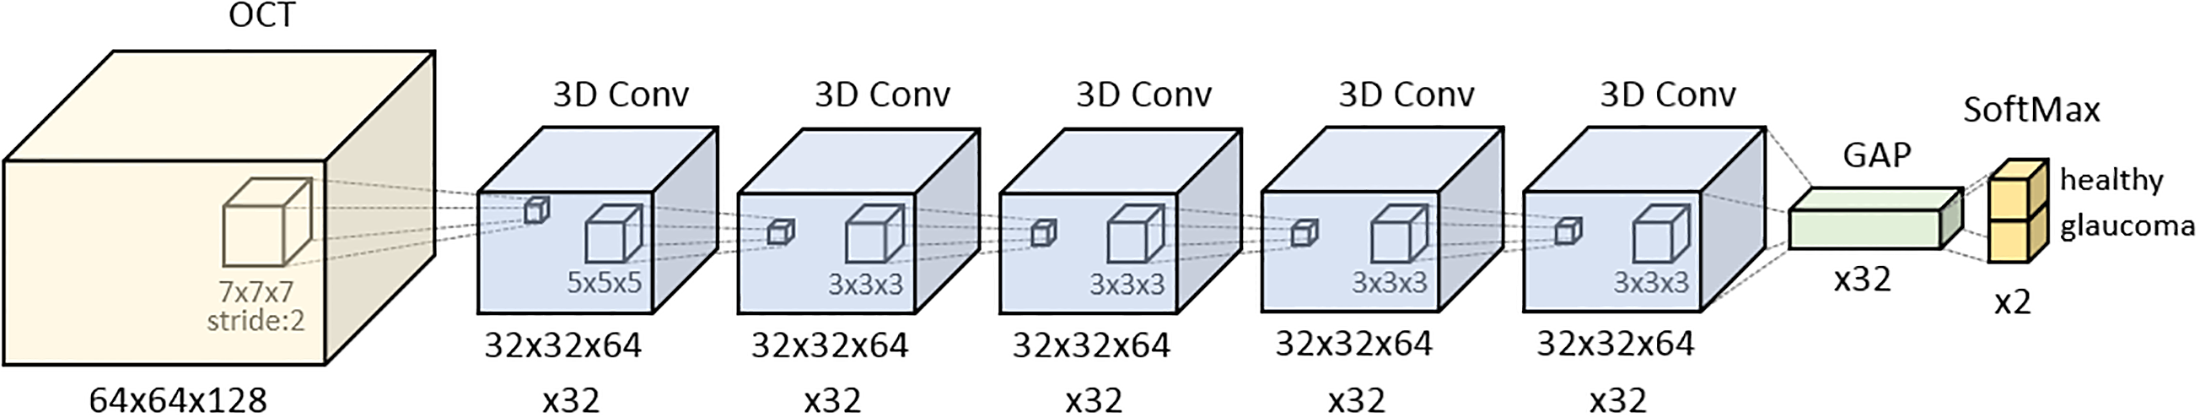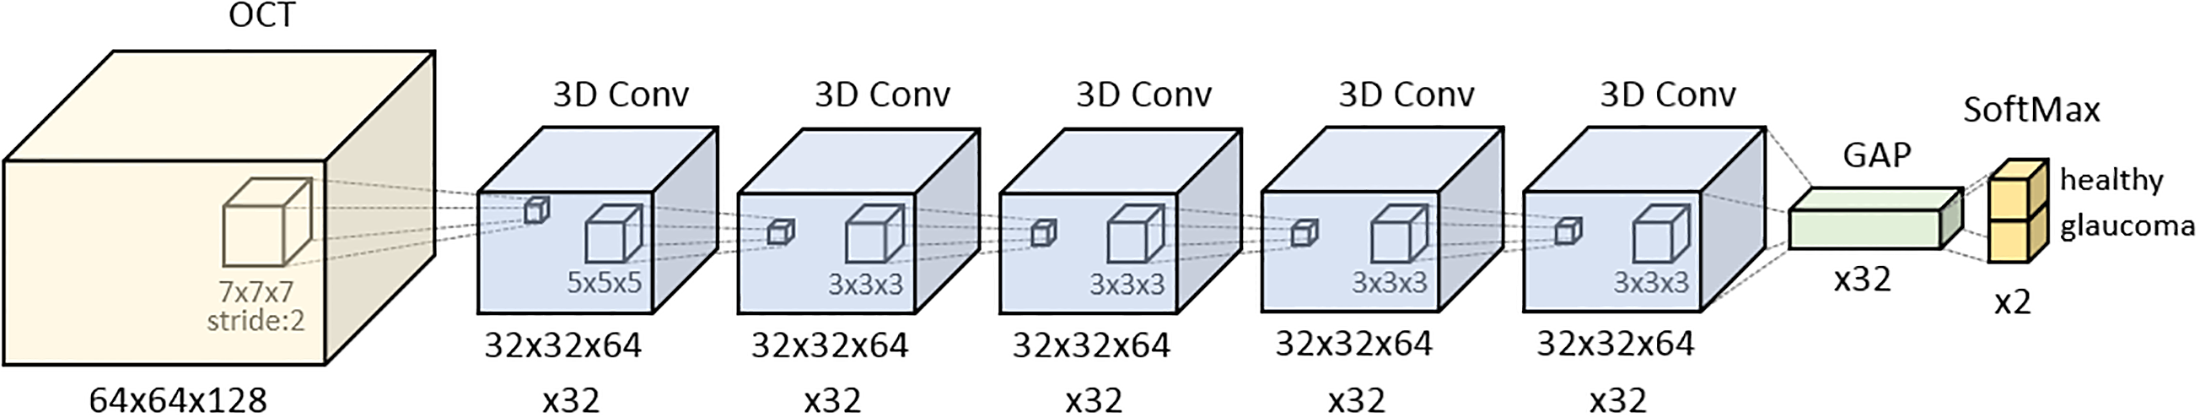

In [8]:
model = Sequential([

    Input(shape=(64, 128, 64, 1)),
    # Layer 1
    Conv3D(32, kernel_size=7, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 2
    Conv3D(32, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 3
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 4
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Layer 5
    Conv3D(32, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),

    # Global Average Pooling
    GlobalAveragePooling3D(),

    # Dense → Softmax (for multi-class CAM support)
    Dense(2, activation='softmax')  # use 1 + sigmoid if binary
])

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=3,
    restore_best_weights=True
)

model.compile(
    optimizer=Nadam(learning_rate=1e-4),
    metrics=['accuracy',AUC(name='auc')],
    loss='binary_crossentropy'
)

# Load volumes for 3D CNN training and run fit
history = model.fit(
    load_images(vX_train_paths,normalized=True),vy_train, 
    validation_data=(load_images(vX_test_paths,normalized=True),vy_test), 
    epochs=100,
    batch_size=8,
    callbacks=[early_stop]
)

I0000 00:00:1756352049.038240 1271345 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1756352056.530032 1271507 service.cc:152] XLA service 0x734e6c0071f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756352056.530066 1271507 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-08-27 23:34:16.615765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756352056.773369 1271507 cuda_dnn.cc:529] Loaded cuDNN version 90700


  2/111 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.0938 - auc: 0.0820 - loss: 0.8265 

I0000 00:00:1756352062.191009 1271507 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5538 - auc: 0.5799 - loss: 0.6814 - val_accuracy: 0.7297 - val_auc: 0.7050 - val_loss: 0.6116
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7883 - auc: 0.8702 - loss: 0.5652 - val_accuracy: 0.7297 - val_auc: 0.6649 - val_loss: 0.5936
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7796 - auc: 0.8554 - loss: 0.5518 - val_accuracy: 0.7297 - val_auc: 0.6527 - val_loss: 0.5916
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.8153 - auc: 0.8972 - loss: 0.5020 - val_accuracy: 0.7297 - val_auc: 0.8298 - val_loss: 0.5821
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8205 - auc: 0.9001 - loss: 0.4828 - val_accuracy: 0.7342 - val_auc: 0.8296 - val_loss: 0.5620
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8132 - auc: 0.8881 - loss: 0.4865 - val_accuracy: 0.7748 - val_auc: 0.8879 - val_loss: 0.4932
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━

In [9]:
loss,acc,auc = model.evaluate(load_images(vX_test_paths,normalized=True),vy_test)
saved_epoch = [ i for i,v in enumerate(history.history['val_auc']) if round(v,4) == round(auc,4) ][0]
saved_epoch

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step - accuracy: 0.7898 - auc: 0.8919 - loss: 0.4388


9

Text(0.5, 1.0, 'AUC over Epochs')

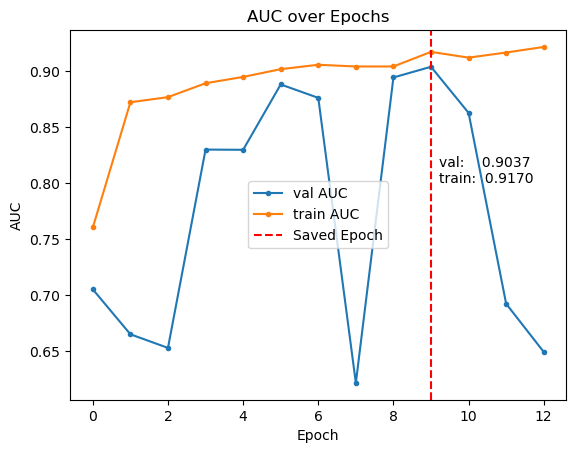

In [10]:
# Plot score progression
plt.plot(history.history['val_auc'], label='val AUC', marker='.')
plt.plot(history.history['auc'], label='train AUC', marker='.')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.axvline(saved_epoch, linestyle='--', c='r', label='Saved Epoch')
plt.text(saved_epoch+.2,.8,f"val:    {auc:.4f}\ntrain:  {history.history['auc'][saved_epoch]:.4f}")
plt.legend()
plt.title('AUC over Epochs')

In [12]:
# n rows by 3 cols
def flatMap(nrows,ncols,opf='dict'):
    rowIndices = [ r for r in range(nrows) ]
    colIndices = [ c for c in range(ncols) ]
    nflat = nrows * ncols
    flatIndices = [ f for f in range(nflat) ]
    fMap = []
    ci = 0
    ri = 0 
    for fi in flatIndices:
        item = (fi,(ri,ci))
        fMap.append(item)
        ci += 1
        if ci == ncols:
            ci = 0
            ri += 1

    if opf == 'basic':
        return fMap
    elif opf == 'dict':
        return dict(fMap)
    elif opf == 'df':
        return pd.DataFrame(dict(fMap))
    elif opf == 'tvfn': #two-variable function of r,c
        def tvfn(row,col):
            fiMatches = [ k for k,(r,c) in dict(fMap).items() if r==row and c==col ]
            if len(fiMatches) == 1:
                return fiMatches[0]
        return tvfn
        
        

tvfn = flatMap(111,3,opf='tvfn')

tvfn(3,0)

9

### Plotting Class Activation Maps (CAMs) 

In [39]:
{i:layer.name for i,layer in enumerate(model.layers)}

{0: 'conv3d',
 1: 'batch_normalization',
 2: 're_lu',
 3: 'conv3d_1',
 4: 'batch_normalization_1',
 5: 're_lu_1',
 6: 'conv3d_2',
 7: 'batch_normalization_2',
 8: 're_lu_2',
 9: 'conv3d_3',
 10: 'batch_normalization_3',
 11: 're_lu_3',
 12: 'conv3d_4',
 13: 'batch_normalization_4',
 14: 're_lu_4',
 15: 'global_average_pooling3d',
 16: 'dense'}

The last convolutional layer, `'conv3d_4'`, ultimately has outputs in the `re_lu_4` layer (index 14).

In [68]:
inputs = model.layers[0].input
outputs = model.layers[14].output

# create a usable function from the last convolutional layer
lastConv = kerasModel(inputs,outputs)
final_dense_weights = model.layers[-1].weights[0].numpy()
sample=0
if sample < len(vX_test_paths):
    sample = load_images(vX_test_paths)[sample][np.newaxis,...]

# Apply the last convolution 
convolved_sample = lastConv(sample)

In [69]:
print(len(convolved_sample),type(convolved_sample))
print(len(convolved_sample[0]),type(convolved_sample[0]))
print(len(convolved_sample[0][0]),type(convolved_sample[0][0]))
print(len(convolved_sample[0][0][0]),type(convolved_sample[0][0][0]))
print(len(convolved_sample[0][0][0][0]),type(convolved_sample[0][0][0][0]))
try:
    print(len(convolved_sample[0][0][0][0][0]),type(convolved_sample[0][0][0][0][0]))
except:
    print(convolved_sample[0][0][0][0][0])

1 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
64 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
32 <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.0, shape=(), dtype=float32)


In [74]:
print(convolved_sample.numpy().shape)
print(convolved_sample[0].numpy().shape)
print(convolved_sample[0][0].numpy().shape)
print(convolved_sample[0][0][0].numpy().shape)
print(convolved_sample[0][0][0][0].numpy().shape)
print(convolved_sample[0][0][0][0][0].numpy().shape)

(1, 32, 64, 32, 32)
(32, 64, 32, 32)
(64, 32, 32)
(32, 32)
(32,)
()


In [75]:
featMaps = convolved_sample[0].numpy()
featMaps.shape

(32, 64, 32, 32)

In [119]:
classIndex=1
cam = np.tensordot(featMaps,final_dense_weights[:,classIndex],axes=([3],[0]))
cam.shape, cam.min(),cam.max()

((32, 64, 32), -6.217577, 3.7432926)

In [121]:
cam_stretch = (cam / cam.max())*255
cam_img = (cam_stretch - cam_stretch.min()).astype(int)
from scipy.ndimage import zoom
cam_img_full = zoom(cam_img,zoom=(2,2,2),order=1)

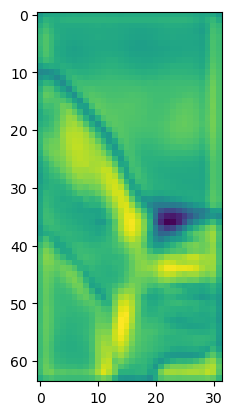

In [122]:
# plt.imshow(cam_img_full[32,:,:])
plt.imshow(zoom(cam,zoom=(2,2,2),order=1)[32,:,:])
plt.imshow(cam[16,:,:])

In [132]:
vX_test_paths.iloc[inde

,normalized_array,display_volume
0,../datasrc/volumesOCT/normalized/p498_Glaucoma...,../datasrc/volumesOCT/POAG-002774-2008-02-19-O...
1,../datasrc/volumesOCT/normalized/p190_Glaucoma...,../datasrc/volumesOCT/POAG-001086-2008-08-04-O...
2,../datasrc/volumesOCT/normalized/p032_Glaucoma...,../datasrc/volumesOCT/POAG-000267-2008-07-28-O...
3,../datasrc/volumesOCT/normalized/p391_Glaucoma...,../datasrc/volumesOCT/POAG-002152-2014-09-17-O...
4,../datasrc/volumesOCT/normalized/p405_Glaucoma...,../datasrc/volumesOCT/POAG-002219-2008-09-08-O...
...,...,...
217,../datasrc/volumesOCT/normalized/p322_Glaucoma...,../datasrc/volumesOCT/POAG-001773-2009-02-03-O...
218,../datasrc/volumesOCT/normalized/p307_Glaucoma...,../datasrc/volumesOCT/POAG-001677-2016-06-20-O...
219,../datasrc/volumesOCT/normalized/p546_Glaucoma...,../datasrc/volumesOCT/POAG-003080-2014-06-25-O...
220,../datasrc/volumesOCT/normalized/p216_Glaucoma...,../datasrc/volumesOCT/POAG-001237-2010-02-24-O...


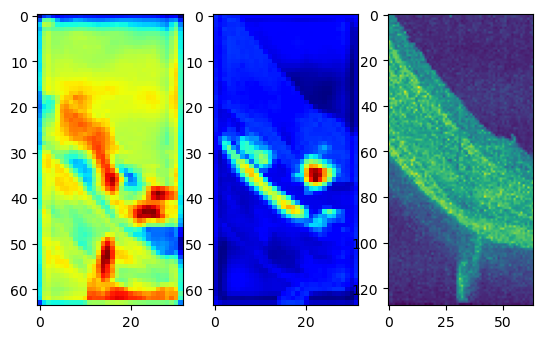

In [137]:
def plotCAMsettrio(index,axis_norm=0):
    _,(a,b,c) = plt.subplots(1,3)
    
    plotCAM(index,0,ax=a)
    plotCAM(index,1,ax=b)
    image = vizInputParser(vX_test_paths.iloc[index,1])
    c.imshow(np.max(image,axis=axis_norm))#,cmap='jet')

plotCAMsettrio(0)

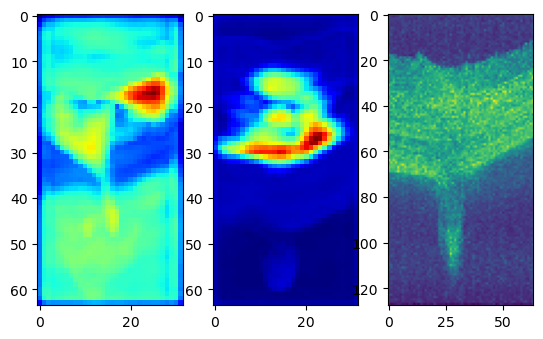

In [138]:
plotCAMsettrio(10)

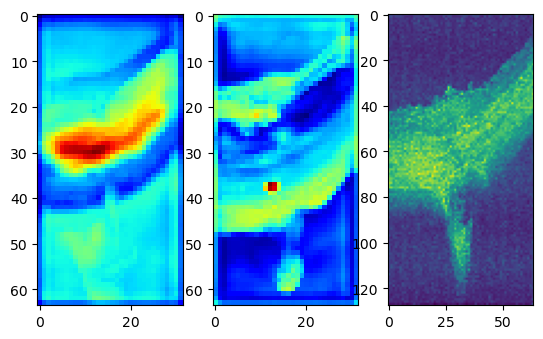

In [140]:
plotCAMsettrio(20)

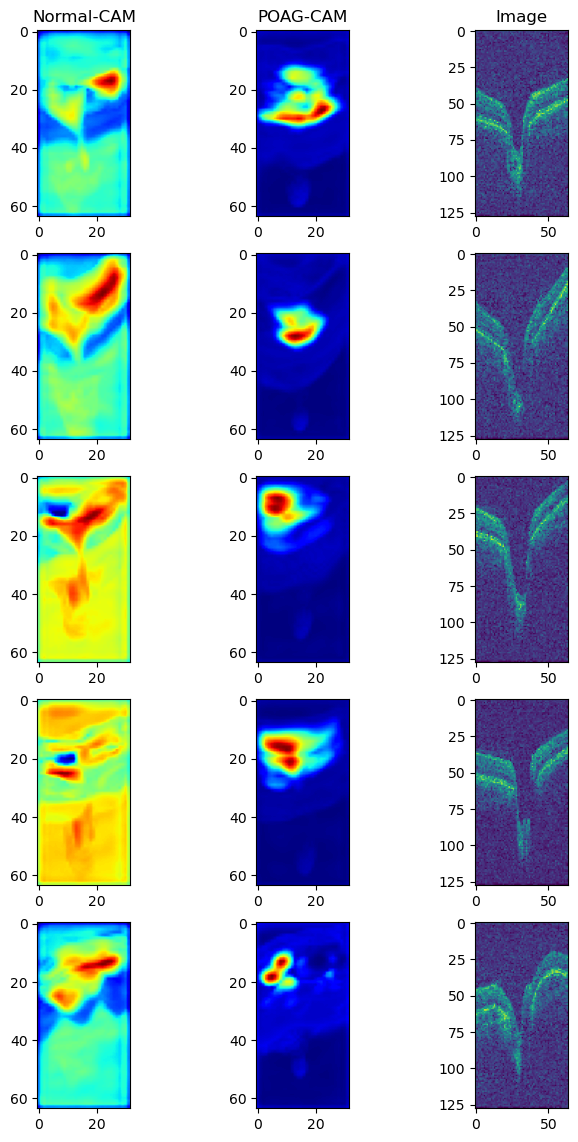

In [28]:
def plotCAM(sample=0, classIndex=1, model=model,ax=None):
    from keras import Model as kerasModel
    
    if type(sample) == int:
        if sample < len(vX_test_paths):
            sample = load_images(vX_test_paths)[sample][np.newaxis,...]
    lastConv = kerasModel(
        inputs=model.layers[0].input,
        outputs=model.layers[-3].output
    )
    
    finDenseWts = model.layers[-1].weights[0].numpy()
    
    featMaps = lastConv(sample)
    featMaps = featMaps[0].numpy()
    
    cam = np.tensordot(featMaps, finDenseWts[:,classIndex],axes=([3],[0]))

    if ax:
        ax.imshow(np.max(cam, axis=0), cmap='jet')
    else:
        plt.imshow(np.max(cam, axis=0), cmap='jet')
        plt.title("Class Activation Map (CAM)")
        plt.colorbar()



viran = range(10,15)
# viran = np.random.choice(range(111),size=5,replace=False)
# viran.sort()
# viran = list(viran)

nvols = len(viran)
ncols = 3

fm = flatMap(nvols,ncols=ncols,opf='dict')
tvfn = flatMap(nvols,ncols=ncols,opf='tvfn')


fig,axs = plt.subplots(nvols,ncols,figsize=(8,14))
axes = axs.flatten()
colTitles = "Normal-CAM POAG-CAM Image".split(' ')
for j,title in enumerate(colTitles):
    axs[0,j].set_title(title)
for vi in viran:
    i = viran.index(vi)
    plotCAM(vi, classIndex=0, ax=axes[tvfn(i,0)])
    
    plotCAM(vi, classIndex=1, ax=axes[tvfn(i,1)])
    axes[tvfn(i,2)].imshow(load_images(vX_test_paths,normalized=False)[vi].squeeze()[32,:,:])
    # fig.text(x=.5,y=.5,s='center')

In [ ]:
plotCAM(vi, classIndex=0, ax=axes[tvfn(i,0)])